(lecture15:measures-of-predictive-accuracy)=
# Measures of Predictive Accuracy


## Training and test datasets

You cannot test how good your model is using the training dataset.
Whatever the metric you use, the performance of your model on the training dataset will always be quite good.
This is because the model is tuned to do well on the training data.
The real question is how well your model does on a dataset it has never see.
This brings us to the concept of a *test dataset*.
How can you make a test dataset?
Well, take whatever data you have and split them into training and test datasets.
For example, you can randomly select 70% of your data and put it in your training set and 30% of the data and put it in your test set.

Let's do this for the motorcyle dataset:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'svg')
import numpy as np
import scipy.stats as st
import pandas as pd
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

In [2]:
# The url of the motorcycle data:
url = 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-297-intro-to-data-science/master/data/motor.dat'
# Download the data
download(url)
# Load the data
data = np.loadtxt('motor.dat')
# The inputs
x = data[:, 0]
# The outputs
y = data[:, 1]

We are going to use the functionality of the Python library [scikitlearn](https://scikit-learn.org/stable/) to split our dataset in to training and test.

In [3]:
from sklearn.model_selection import train_test_split

# Here is how you use it
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

Let's plot the training and the test datasets in different colors:

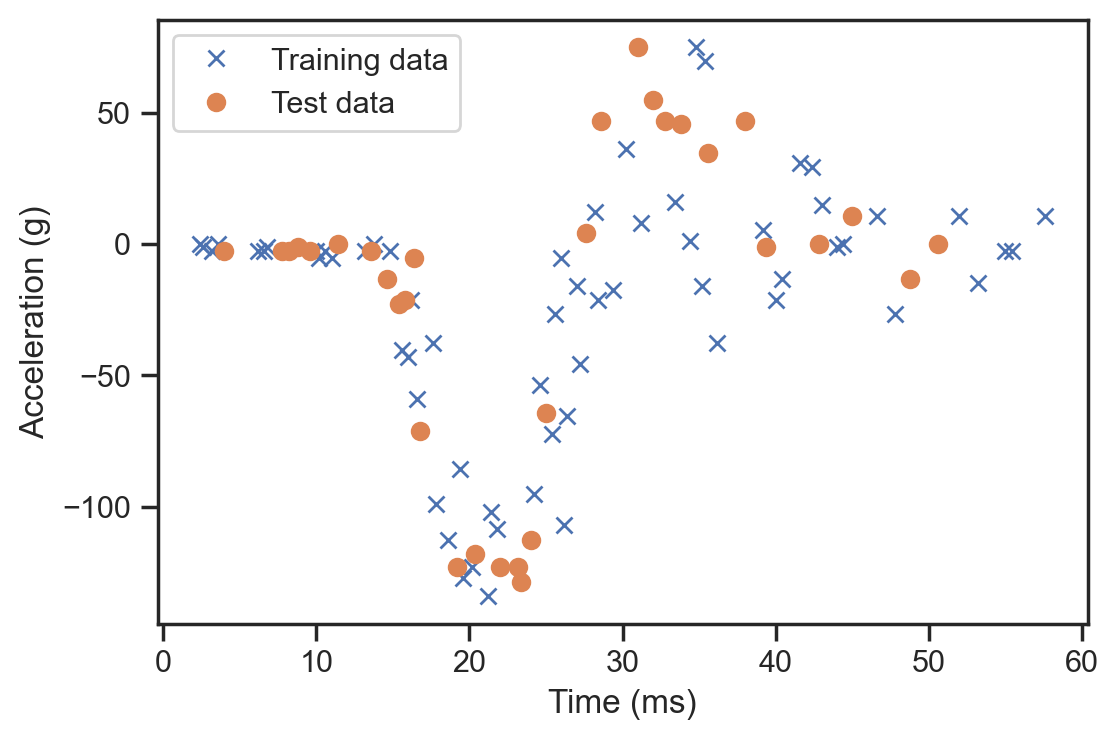

In [4]:
fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best');

## Fit the model on the training set

Let's repeat here the code that calculates the design matrix for polynomial, Fourier, and radial basis functions:

In [5]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    
        L           -       The "length" of the domain.
        num_terms   -       How many Fourier terms do you want. This is not the number
                            of basis functions you get. The number of basis functions
                            is 1 + num_terms / 2. The first one is a constant.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """
    Radial basis functions design matrix.
    
    Arguments:
        x          -     the input points on which you want to evaluate the
                         design matrix
        x_center   -     the centers of the radial basis functions
        ell        -     the lengthscale of the radial basis function
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

Let's fit a polynomial model like before:

In [6]:
degree = 3
Phi_poly_train = get_polynomial_design_matrix(x_train[:, None], degree)
w_poly, _, _, _ = np.linalg.lstsq(Phi_poly_train, y_train, rcond=None)

Because this is a nice 1D problem, you have the luxury of plotting your fitting model and comparing it to the test data.
Here it is:

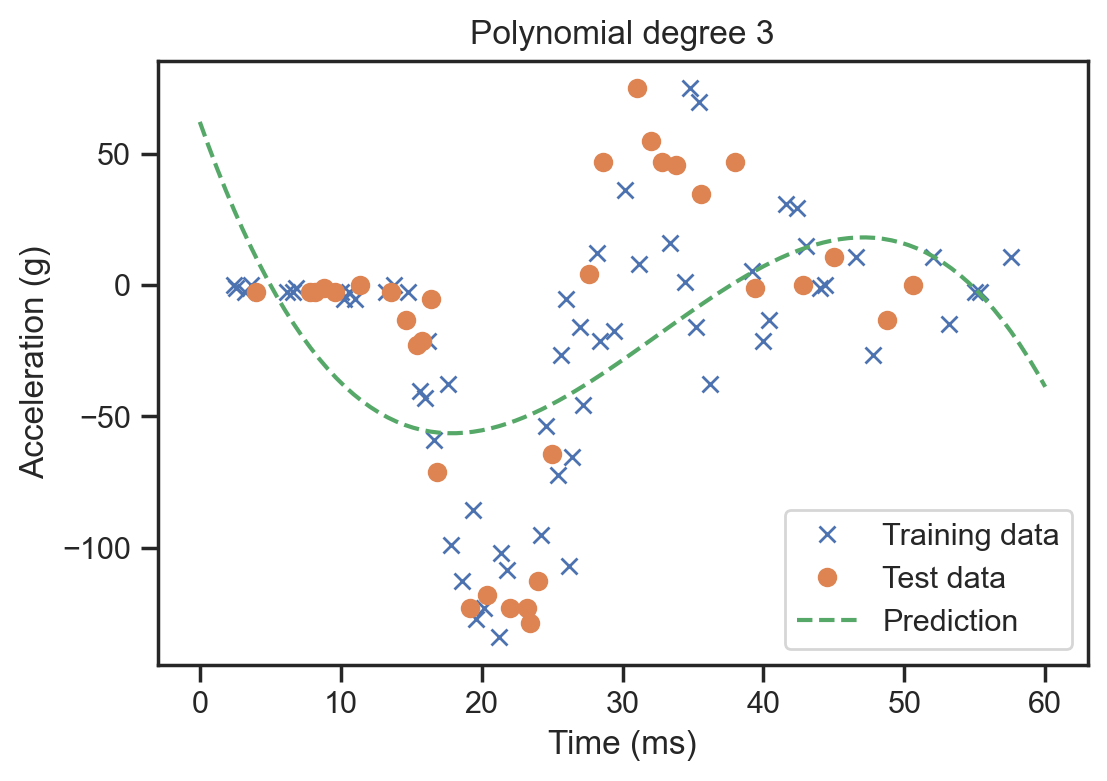

In [7]:
xx = np.linspace(0, 60, 100)
Phi_poly_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_predict = np.dot(Phi_poly_xx, w_poly)
fig, ax = plt.subplots()
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best');

## Test the model with the test set: The predictions-vs-observations plot

As you can imagine, this is not something that you can do if the input has more than two dimensions.
What do you do in that case?
A very nice plot you can do is the predictions-vs-observations plot for the test data.
Here is how it looks:

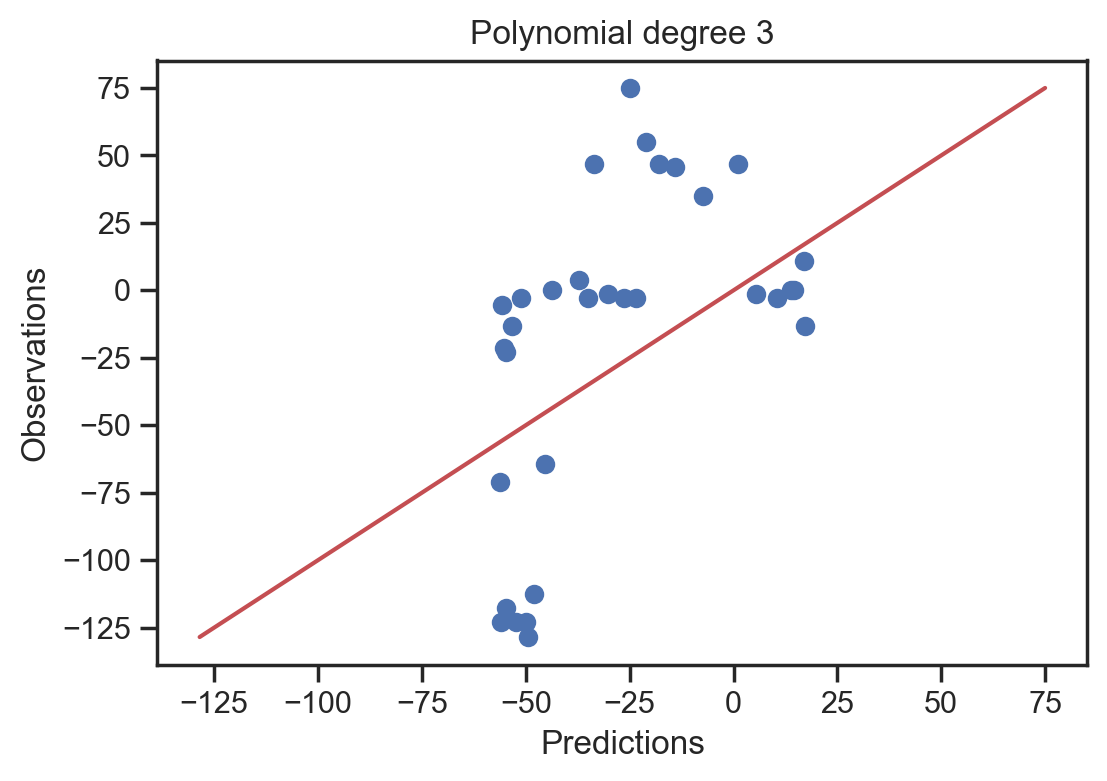

In [8]:
Phi_poly_test = get_polynomial_design_matrix(x_test[:, None], degree)
y_test_predict = np.dot(Phi_poly_test, w_poly)

fig, ax = plt.subplots()
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(y_test_predict, y_test, 'o')
yys = np.linspace(y_test.min(), y_test.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

Notice that in this plot I have included a red line that goes through the origin at has a 45 degree angle with the x-axis.
This red line marks the perfect fit, i.e., a perfect agreement between the predictions and the observations.
In other words, the closer the blue dots get to the red line, the better the model.

## The mean squared error

The predictions-vs-observations plot is nice.
But sometimes you just want to characterize your model using a number.
The mean squared error or (MSE) is such a scalar measure of the goodness of fit.
The MSE is the *mean* of the *sum* of the *square* of the *prediction error* over your test data.
If we assume that you have $N_t$ test data points with inputs $x_{t,i}$ and outputs $y_{t,i}$, the the MSE of your model is given by the formula:

$$
\text{MSE} = \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{N_t}.
$$

In the polynomial model we fitted above, it is:

In [9]:
MSE_poly = np.mean((y_test_predict - y_test) ** 2)
print('MSE_poly = {0:1.2f}'.format(MSE_poly))

MSE_poly = 2512.70


Now, it is obvious that smaller MSE means better model.
But it is a bit hard to understand the absolute meaning of the MSE.
So, some times we look at the relative MSE or (RMSE).
RMSE is the MSE of your model divided by the MSE of the simplest possible model you could make.
Okay. What is the simplest possible model you could make?
It is a constant model.
A model that predicts the same value for the output $y$ no matter what the input $x$ is.
So, mathematically the model is:

$$
y_{\text{simplest}} = c,
$$

for some constant $c$. What is the best such constant?
Well, you can fit it by minimizing the sum of square errors for this simple model.
If you do it, you will get, very intuitively, that the constant should be the empirical average of your training data, i.e.,

$$
y_{\text{simplest}} = \hat{\mu} = \frac{1}{N}\sum_{i=1}^Ny_i.
$$

So, the MSE of this simple model is just:

$$
\text{MSE}_{\text{simplest}} = \frac{\sum_{i=1}^{N_t}\left(y_{t,i} - \hat{\mu}\right)^2}{N_t}.
$$

And we define RMSE to be:

$$
\text{RMSE} = \frac{\text{MSE}}{\text{MSE}_{\text{simplest}}} = \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{\sum_{i=1}^{N_t}\left(y_{t,i} - \hat{\mu}\right)^2}.
$$

Now, RMSE has an intuitive meaning.
If it is smaller than one, then this means that your model is doing something better than the simplest possible model.
And the smaller it is, the better you do compared to the simplest model.
If the RMSE is greater than one, then your model is really really bad...

```{note}
Sometimes the acronym RMSE is used for the root mean square error which is just the square root of the MSE.
```

Let's find the RMSE for our case:

In [10]:
mu = y_train.mean()
MSE_simplest = np.mean((y_test - mu) ** 2)
print('MSE_simplest = {0:1.2f}'.format(MSE_simplest))
RMSE_poly = MSE_poly / MSE_simplest
print('RMSE_poly = {0:1.2f}'.format(RMSE_poly))

MSE_simplest = 3365.99
RMSE_poly = 0.75


## Coefficient of determination $R^2$

The coefficient of determination is defined by:

$$
R^2 = 1 - \text{RMSE} = 1 - \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{\sum_{i=1}^{N_t}\left(y_{t,i} - \hat{\mu}\right)^2}.
$$

This measure is telling you how much of the percentage of the variance of the test data is explained by your model.
So, here you want to get as close to one as possible.

Let's see what we get in our case:

In [11]:
R2_poly = 1 - RMSE_poly
print('R2 = {0:1.2f}'.format(R2_poly))

R2 = 0.25


So, in this example our model explains about 23% of the variance of the test data?
What is the rest?
Well, the rest explained by the measurement noise variance...

### Questions

+ Experiment with polynomials of degree 4, 5, 10, 20
+ When are we underfitting?
+ When are we overfitting?
+ Which degree (if any) gives you the best fit?
+ Use the code blocks below to repeat this analysis for the Fourier basis and the radial basis functions. Which choice of the three basis functions seems to be better? Why?

## Example: Repeat the fitting using Fourier features

Below, I train a model on the same dataset but using Fourier features instead of polynomials.
Let's see what we get.

In [12]:
fourier_terms = 10
fourier_L = 60.0
Phi_fourier_train = get_fourier_design_matrix(x_train[:, None], fourier_L, fourier_terms)
w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train, rcond=None)

The predictions plot:

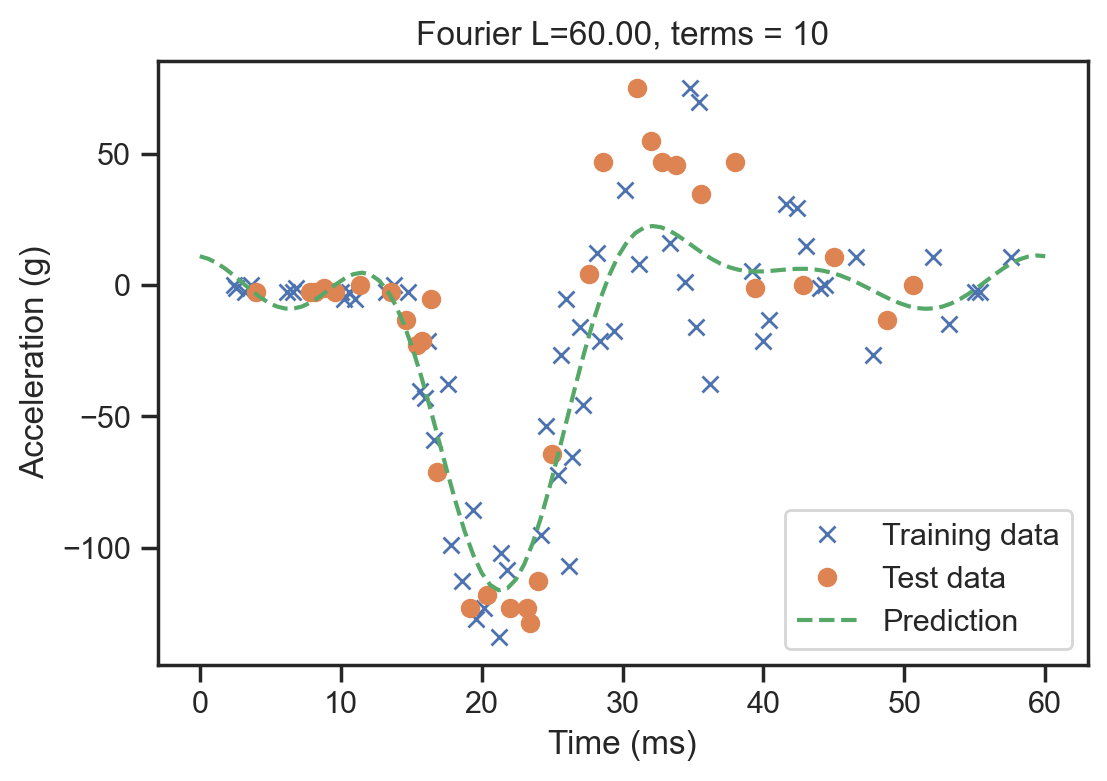

In [13]:
xx = np.linspace(0, 60, 100)
Phi_fourier_xx = get_fourier_design_matrix(xx[:, None], fourier_L, fourier_terms)
yy_predict = np.dot(Phi_fourier_xx, w_fourier)
fig, ax = plt.subplots()
ax.set_title('Fourier L={0:1.2f}, terms = {1:d}'.format(fourier_L, fourier_terms))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best');

And here is the predictions-vs-observations plot:

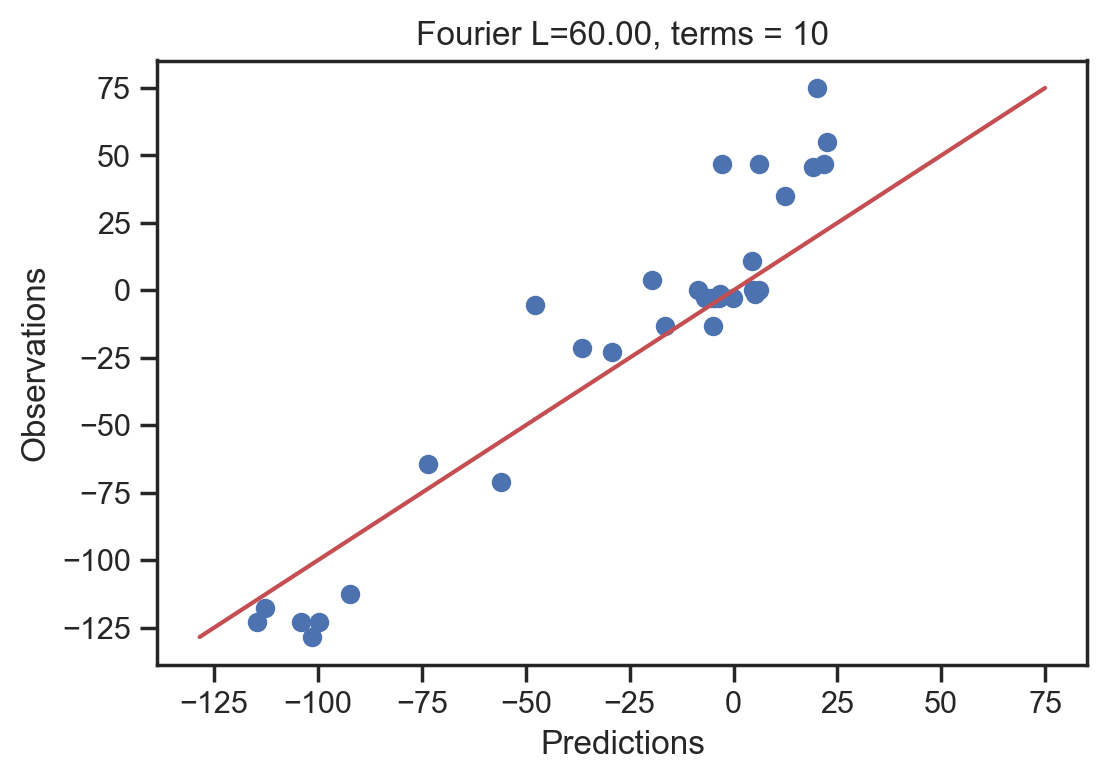

In [14]:
Phi_fourier_test = get_fourier_design_matrix(x_test[:, None], fourier_L, fourier_terms)
y_test_predict = np.dot(Phi_fourier_test, w_fourier)
fig, ax = plt.subplots()
ax.set_title('Fourier L={0:1.2f}, terms = {1:d}'.format(fourier_L, fourier_terms))
ax.plot(y_test_predict, y_test, 'o')
yys = np.linspace(y_test.min(), y_test.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

And the error metrics we developed:

In [15]:
MSE_fourier = np.mean((y_test_predict - y_test) ** 2)
RMSE_fourier = MSE_fourier / MSE_simplest
R2_fourier = 1 - RMSE_fourier
print('MSE_fourier = {0:1.2f}'.format(MSE_fourier))
print('RMSE_fourier = {0:1.2f}'.format(RMSE_fourier))
print('R2 = {0:1.2f}'.format(R2_fourier))

MSE_fourier = 481.61
RMSE_fourier = 0.14
R2 = 0.86


You see that this does much much better than the polynomial model by all measures.
In particular, R2 is telling us that 81% of the variance of the test data is explained by our model.

### Questions
+ Modify the code blocks above to use radial basis functions instead of the Fourier basis.